# Monkey Business
## Preprocessing and Decomposition to Build Neural Decoders
Tyler Yamori-Little

The outlook of current neuroscience research is very promising. Due to newfound knowledge about the nature of the brain, it becomes possible to build and train decoders to predict motion from brain signals.

The animal brain is a dynamical system containing well over 85 billion neurons. These neurons communicate with eachother on the milisecond timescale through signals. Such links are detecable by looking at the electropotential current going through a given neuron. This is almost always constant and appears almsot random. However, there are brief moments of a higher electropotential. This phenomeon is called a spike and it is believed that these spikes are the driving force behind animal functions. 

Luckily, out of all the neurons in the brain, those within the motor cortex and somatosensory cortex play a significant role in determing motion. Thus, by looking at the interactions between these specific neurons within the two cortexes, it becomes much more probable in finding a correlation to motion. 

This notebook is intended to be a guide for a novice (such as myself) in the field of systems neuroscience who seeks to understand neural data.

## Import Data

The dataset that is used was recorded by O'Doherty et al and can be found here: https://zenodo.org/record/3854034#.YuLAeuzMKJl. The subject is a Rhesus macaque monkey named Loco. Two multielectrode silicon utah arrays were planted into the primary motor cortex(m1) and the somatosensory cortex(s1). These arrays recorded neural signals from local neuron populations at a rate of 24.4khz. Signals crossing a threshold of 3.5-4 times the standard deviation were timestamped and sorted into units. Units refer to discovered neurons using pca reduction and clustering. Furthermore, data is filtered using a casual 4th order bandpass butterworth filter with a low of 500hz and high of 5000hz. This was already preprocessed thanks to the research group. Correspoding cursor data and finger position data were recorded as well, sampled at 250hz. All data is stored as a MATLAB mat file

A trial is a standard reach trial where the subject has to reach a tile on a screen. Once reached, a juice reward is given. A sample run can be found here: https://www.youtube.com/watch?v=bPkpdpm03z8. 

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
##using h5 file to access mat data
loco = h5py.File('loco_20170213_02.mat','r')
list(loco.keys())

['#refs#',
 'chan_names',
 'cursor_pos',
 'finger_pos',
 'spikes',
 't',
 'target_pos',
 'wf']

In [9]:
#Used to determine what data belongs to the m1 versus s1 arrays
chan_names = loco['chan_names']
channel_names = np.zeros(192,dtype='object')
num_of_channels = chan_names.size
for i in range(num_of_channels):
    channel_names[i] = loco[chan_names[0][i]]

In [10]:
print(chr(channel_names[0][0]),chr(channel_names[0][1])) #m1 
print(chr(channel_names[96][0]),chr(channel_names[96][1])) #s1

M 1
S 1


In [11]:
time = loco['t'][0]
cumulative_time = time[-1]-time[0]
minutes = cumulative_time / 60
print("The length of the eperiment was ",minutes, "minutes long")

The length of the eperiment was  40.29073333333334 minutes long


## Construct Cursor Data

Constructing the cursor data in terms of position to a target is useful in understanding what a singular trial looks like. This leads to a general idea of where the start and end times of a trial are. 

In [12]:
cursor_pos = loco['cursor_pos']
time = loco['t'][0]
x_cursor = cursor_pos[0,:]
y_cursor = cursor_pos[1,:]
target_pos = loco['target_pos']
x_target = target_pos[0,:]
y_target = target_pos[1,:]

(604362,)


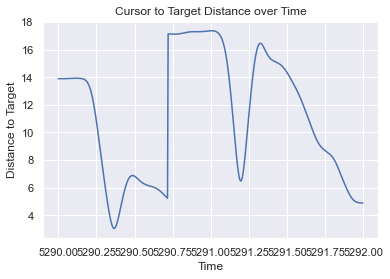

In [13]:
x_distance = abs(x_cursor-x_target)
y_distance = abs(y_cursor-y_target)
x_squared = np.power(x_distance,2)
y_squared = np.power(y_distance,2)
distance_to_target = np.sqrt(x_squared + y_squared) #standard distance formula
print(distance_to_target.shape)

plt.plot(time[0:500],distance_to_target[0:500])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Cursor to Target Distance over Time')
plt.show()

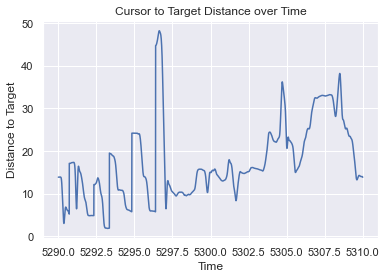

In [14]:
plt.plot(time[0:5000],distance_to_target[0:5000])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Cursor to Target Distance over Time')
plt.show()

## Find Trial Boundaries

The trial begins when a new target appears. This correlates to the cursor/hand being a considerable distance away from the target. As the trial progresses, the cursor/hand approaches the target and the distance to the target decreases. The trial concludes when the monkey recieves its reward(juice) while the hand to target position remains consistently low. 

In [15]:
x_target_shifted = [0]
x_target_original = x_target
x_target_shifted = np.append(x_target_shifted,x_target)
x_target_original = np.append(x_target_original,0)

In [16]:
x_target_difference = x_target_shifted - x_target_original
trial_boundary_indexes = []
for i, j in enumerate(x_target_difference):
    if (j!=0):
        trial_boundary_indexes = np.append(trial_boundary_indexes, i)
        
trial_boundary_indexes = trial_boundary_indexes.astype(int)

In [93]:
boundaries = trial_boundary_indexes[0:10]
print(boundaries)
yboundaries = [5] * len(boundaries)
print(yboundaries)

[    0   180   584   839  1207  1597  7593  8339  8656 10007]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


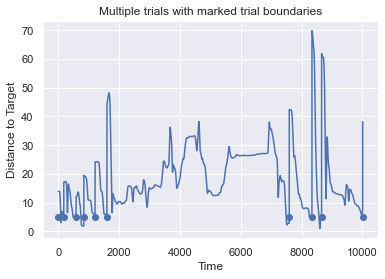

In [101]:
plt.plot(distance_to_target[0:10008])
plt.scatter(boundaries, yboundaries)
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Multiple trials with marked trial boundaries')
plt.show()

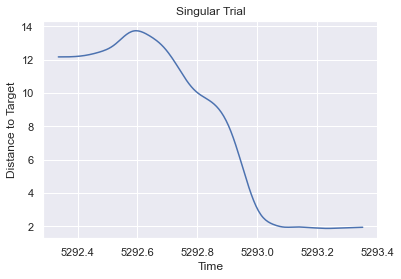

In [99]:
plt.plot(time[584:839],distance_to_target[584:839])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('Singular Trial')
plt.show()

## Kinematics and Smoothing

Cursor data is a linear transformation of finger position. This notebook will look at mostly kinematics derived from x and y positions alone and won't use metrics of azumith or roll. Furthermore, to easily visualize the data, cursor data was used in lue of finger position data to calculate kinematics. As higher order kinematics are derived, data becomes more prone to noise from jitters found in both how to data was collected and the monkey's fingers. To filter out this noise, a fourier transform and subsequent spectral analysis is used to differentiate the noise from the general data trend. The separation of the two is achieved from preforming a low-band pass butterworth filter. 

In [100]:
finger_pos = loco['finger_pos']
time = loco['t'][0]
x_finger = finger_pos[1]
y_finger = finger_pos[2]

In [20]:
np.max(y_finger)

6.243064151515015

In [21]:
np.min(y_finger)

-7.860908432574234

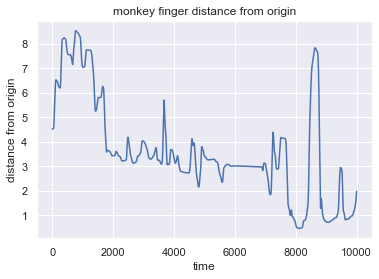

In [98]:
distance = np.sqrt(np.power(x_finger,2) + np.power(y_finger,2))
plt.plot(distance[0:10000])
plt.xlabel('time')
plt.ylabel('distance from origin')
plt.title('monkey finger distance from origin')
plt.show()

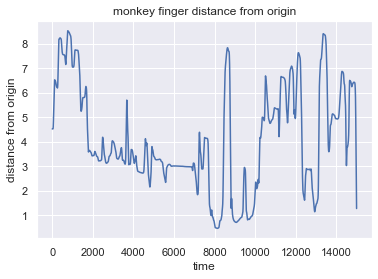

In [78]:
distance = np.sqrt(np.power(x_finger,2) + np.power(y_finger,2))
plt.plot(distance[0:15000])
plt.xlabel('time')
plt.ylabel('distance from origin')
plt.title('monkey finger distance from origin')
plt.show()

In [57]:
from sklearn import preprocessing
#distance_normalized = np.reshape(distance, (-1,1)
distance_normalized = preprocessing.normalize([distance])

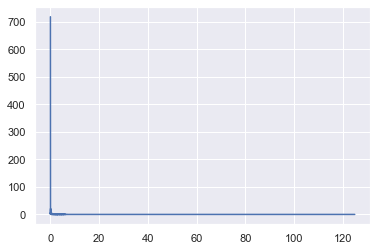

In [73]:
from scipy.fft import rfft, rfftfreq

N = distance.size
SAMPLE_RATE = 250

# Note the extra 'r' at the front
yf = rfft(distance_normalized)
yf = np.reshape(yf, yf.shape[1])
xf = rfftfreq(N, 1 / SAMPLE_RATE)


plt.plot(xf, np.abs(yf))
plt.show()

302182

In [40]:
yf

array([2646439.25041961    -0.j        ,  -18465.37700207+50739.78503691j,
         71096.85421909+97577.5050883j , ...,
         17108.38068679-71919.70363257j,   71096.85421909-97577.5050883j ,
        -18465.37700207-50739.78503691j])

In [17]:
#data is at .04s itervals. Velocity calculated using .16s widths
offset = np.zeros(4)
distance_shifted = offset
distance_shifted = np.append(distance_shifted,distance)
distance_original = distance
distance_original = np.append(distance_original,offset)

distance_difference = distance_shifted - distance_original

t_step = time[4]-time[0]
velocity = distance_difference / t_step
velocity = np.delete(velocity,[0,1,2,3])

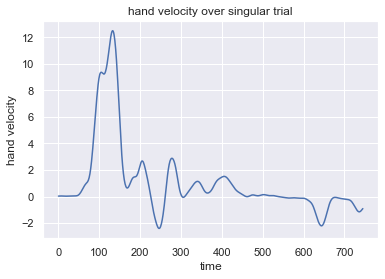

In [18]:
plt.plot(velocity[7593:8339])
plt.xlabel('time')
plt.ylabel('hand velocity')
plt.title('hand velocity over singular trial')
plt.show()

In [19]:
offset = np.zeros(4) 
velocity_shifted = offset
velocity_shifted = np.append(velocity_shifted,velocity)
velocity_original = velocity
velocity_original = np.append(velocity_original,offset)

velocity_difference = velocity_shifted - velocity_original

t_step = time[4]-time[0]
acceleration = velocity_difference / t_step
acceleration = np.delete(acceleration,[0,1,2,3])
acceleration.size

604362

In [20]:
print(distance.size)
print(velocity.size)
print(acceleration.size)

604362
604362
604362


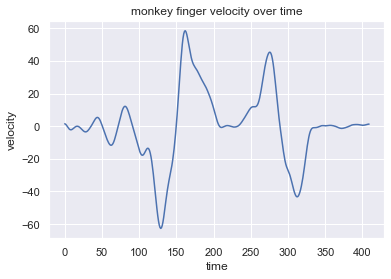

In [21]:
plt.plot(acceleration[800:1210])
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('monkey finger velocity over time')
plt.show()

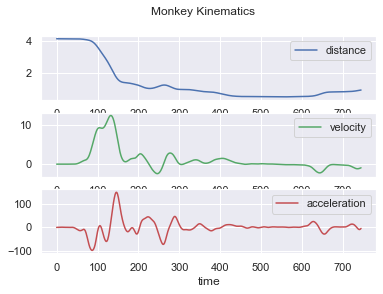

In [22]:
fig, axs = plt.subplots(3)
fig.suptitle('Monkey Kinematics')
axs[0].plot(distance[7593:8339],color = 'b', label = 'distance')
axs[1].plot(velocity[7593:8339],color = 'g', label = 'velocity')
axs[2].plot(acceleration[7593:8339],color = 'r', label = 'acceleration')

for i,j in enumerate(axs):
    axs[i].legend()
plt.xlabel('time')
plt.show()

## Constructing Raster

A raster refers to a binary array of spikes over multiple trials. A 1 refers to a spike existing for a given timestep and 0 refers to no spikes at a given timestep. For this experiment, spikes were recorded at a greater sampling rate then the kinematic data. Therefore, it is necessary to round the spike times to match the kinematic data or to interpolate the kinematic data to match the spike times. The following functions rounds the spike times and concatenates all times for a given tetrode. Thus, the time step is chosen to be 250hz(kinematic sampling rate). 

In [23]:
def extractSpikeData(dataset):
    #h5 uses object references to store data. This function extracts them.
    #input: dataset name where 'spikes' is the name of spike dataset
    #output: spike timstamps in array
    
    spikes = dataset['spikes']
    spike_data = np.zeros((spikes.shape),dtype='object')
    num_of_channels = len(spike_data[0])
    num_of_units = len(spike_data)
    for i in range(num_of_units):
        for j in range(num_of_channels):
            spike_data[i][j] = dataset[spikes[i,j]][0]
            
    return spike_data

In [24]:
def roundSpikes(spikes_at_channel):
    #spikes and kinematic data are misaligned in sampling rate. This function returns
    #the indexes of spike timestamps rounded to 25hz to then be used for raster construction.
    #input: vector of spikes at a channel to round
    #output: a vector of rounded spike indexes
    
    t_step = round(time[1]-time[0],3)
    t_step_for_index = 1/t_step
    t_step_for_index
    rounded_spikes = []
    for i in range(spikes_at_channel.size):
        rounded_spikes = np.append(rounded_spikes, round(spikes_at_channel[i] * t_step_for_index)/t_step_for_index)
        
    rounded_spikes = np.delete(rounded_spikes, rounded_spikes > (time[-1] - time[0]))
    rounded_spikes_index = (rounded_spikes * t_step_for_index).astype(int)
    return rounded_spikes_index

In [25]:
def constructRaster(dataset, isSorted):
    #function to construct the raster.
    #input: The name of the h5 dataset (must have 'spikes' as the key for spike data.
    #1 to include only sorted units. 0 for all spikes.
    #output: full raster where 1 is a spike and 0 is no spike at a given time.
    
    spike_data = extractSpikeData(dataset)
    raster = np.zeros(time.size)
    num_of_channels = len(spike_data[0])
    num_of_units = len(spike_data)
    units_index = 0
    
    if isSorted: #flag to construct raster based on if raster will contain sorted units or not
        units_index = 1
    for j in range(num_of_channels):
        spikes_at_channel = []
        time_at_channel = np.zeros(time.size)
        for i in range(units_index,num_of_units):
            spikes_at_channel = np.append(spikes_at_channel, spike_data[i,j])
            spikes_at_channel.sort()
            spikes_at_channel = np.delete(spikes_at_channel,spikes_at_channel == 0)

        spikes_at_channel = spikes_at_channel - time[0]
        spikes_at_channel = np.delete(spikes_at_channel,spikes_at_channel <= 0)
        rounded_spikes_at_channel = roundSpikes(spikes_at_channel)
        time_at_channel[rounded_spikes_at_channel] = 1
        raster = np.vstack((raster, time_at_channel))
    raster = np.delete(raster, 0, axis=0)
    return raster

In [26]:
raster_unsorted = constructRaster(loco, 0)
raster_sorted = constructRaster(loco, 1)

In [27]:
m1_unsorted = raster_unsorted[:96]
s1_unsorted = raster_unsorted[96:]
m1_sorted = raster_sorted[:96]
s1_sorted = raster_sorted[96:]

In [28]:
#store data into a new hdf5 file to be extracted later.
with h5py.File('monkeyData.hdf5','w') as monkey:
    monkey.create_dataset("raster_sorted", dtype='i', data=raster_sorted)
    monkey.create_dataset("raster_unsorted", dtype='i', data=raster_unsorted)
    monkey.create_dataset("m1_sorted", dtype='i', data=m1_sorted)
    monkey.create_dataset("s1_sorted", dtype='i', data=s1_sorted)
    monkey.create_dataset("m1_unsorted", dtype='i', data=m1_unsorted)
    monkey.create_dataset("s1_unsorted", dtype='i', data=s1_unsorted)
    monkey.create_dataset("hand_distance", dtype='f', data=distance)
    monkey.create_dataset("hand_velocity", dtype='f', data=velocity)
    monkey.create_dataset("hand_acceleration", dtype='f', data=acceleration)

In [29]:
monkey_data = h5py.File('monkeyData.hdf5', 'r')
monkey_data.keys()

<KeysViewHDF5 ['hand_acceleration', 'hand_distance', 'hand_velocity', 'm1_sorted', 'm1_unsorted', 'raster_sorted', 'raster_unsorted', 's1_sorted', 's1_unsorted']>

## Read Data

In [30]:
m1_sorted = np.array(monkey_data['m1_sorted'])
m1_unsorted = np.array(monkey_data['m1_unsorted'])
s1_sorted = np.array(monkey_data['s1_sorted'])
s1_unsorted = np.array(monkey_data['s1_unsorted'])
raster_sorted = np.array(monkey_data['raster_sorted'])
raster_unsorted = np.array(monkey_data['raster_unsorted'])
hand_distance = np.array(monkey_data['hand_distance'])
hand_velocity = np.array(monkey_data['hand_velocity'])
hand_acceleration = np.array(monkey_data['hand_acceleration'])

## Time Selection

After the monkey has successfully reached a target, juice is dispensed. This period invovles no movement and thus does not play a significant role in either the m1 or s1 cortexes. Therefore, these windows of time are cut out to not interfere with decoding. In this section, 200ms is used as a manual cutoff selection. This is then used for the regressions that follow. It is possible to change this cutoff as one sees fit.

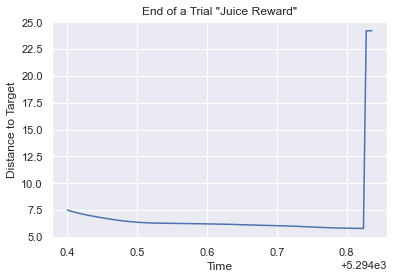

In [31]:
plt.plot(time[1100:1210],distance_to_target[1100:1210])
plt.xlabel('Time')
plt.ylabel('Distance to Target')
plt.title('End of a Trial "Juice Reward"')
plt.show()

In [32]:
trial_boundary_indexes[0:20]

array([    0,   180,   584,   839,  1207,  1597,  7593,  8339,  8656,
       10007, 11034, 11810, 12168, 13035, 13411, 13987, 14357, 14820,
       15288, 15576])

In [33]:
#around 200ms to 500ms for juice reward
juice_reward_times = []
trial_boundary = np.delete(trial_boundary_indexes,[0])
window_size = 50
for i,boundary in enumerate(trial_boundary):
    juice_reward = np.arange(boundary - window_size,boundary)
    juice_reward_times = np.append(juice_reward_times, juice_reward)
        
juice_reward_times = juice_reward_times.astype(int)
juice_reward_times[0:200]

array([ 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,
        141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
        152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,
        163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,
        174,  175,  176,  177,  178,  179,  534,  535,  536,  537,  538,
        539,  540,  541,  542,  543,  544,  545,  546,  547,  548,  549,
        550,  551,  552,  553,  554,  555,  556,  557,  558,  559,  560,
        561,  562,  563,  564,  565,  566,  567,  568,  569,  570,  571,
        572,  573,  574,  575,  576,  577,  578,  579,  580,  581,  582,
        583,  789,  790,  791,  792,  793,  794,  795,  796,  797,  798,
        799,  800,  801,  802,  803,  804,  805,  806,  807,  808,  809,
        810,  811,  812,  813,  814,  815,  816,  817,  818,  819,  820,
        821,  822,  823,  824,  825,  826,  827,  828,  829,  830,  831,
        832,  833,  834,  835,  836,  837,  838, 11

In [34]:
#Delete the end of trial juice reward times as it will affect the BMI decoder learning.
m1_sorted = np.delete(m1_sorted,juice_reward_times, axis = 1)
m1_unsorted = np.delete(m1_unsorted,juice_reward_times, axis = 1)
s1_sorted = np.delete(s1_sorted,juice_reward_times, axis = 1)
s1_unsorted = np.delete(s1_unsorted,juice_reward_times, axis = 1)
raster_sorted = np.delete(raster_sorted,juice_reward_times, axis = 1)
raster_unsorted = np.delete(raster_unsorted,juice_reward_times, axis = 1)
hand_distance = np.delete(hand_distance,juice_reward_times)
hand_velocity = np.delete(hand_velocity,juice_reward_times)
hand_acceleration = np.delete(hand_acceleration,juice_reward_times)

## Data Smoothing

Data in itself contains a certain amount of noise. This section focuses on the noise associated with the kinematic recordings. Aside from noise gathered from the input device, shakiness of the hand and hesitation can lead to additional variance. Thus, smoothing the data is vital in training a decoder to map out the general direction of motion without overfitting to noise!

In [35]:
#A Savitzky–Golay filter is used for this section. Other filters may work as well.
from scipy.signal import savgol_filter 

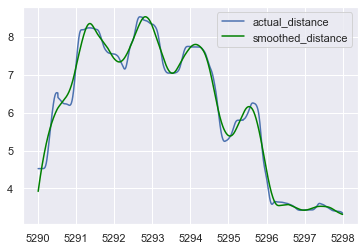

In [36]:
smoothed_distance = savgol_filter(hand_distance, 251, 3)
plt.plot(time[0:2000], hand_distance[0:2000], label = 'actual_distance')
plt.plot(time[0:2000], smoothed_distance[0:2000], color='green', label = 'smoothed_distance')
plt.legend()
plt.show()

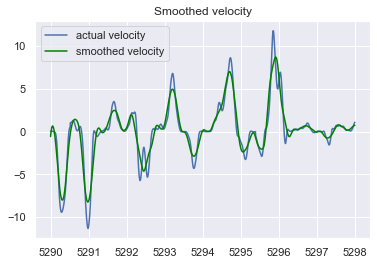

In [37]:
smoothed_velocity = savgol_filter(hand_velocity, 121, 3)
plt.plot(time[0:2000], hand_velocity[0:2000], label = 'actual velocity')
plt.plot(time[0:2000], smoothed_velocity[0:2000], color='green', label = 'smoothed velocity')
plt.title("Smoothed velocity")
plt.legend()
plt.show()

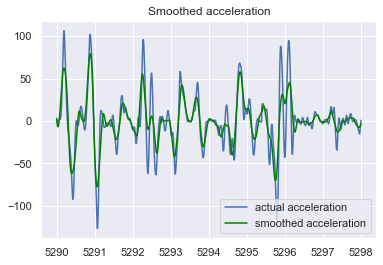

In [38]:
smoothed_acceleration = savgol_filter(hand_acceleration, 81, 3)
plt.plot(time[0:2000], hand_acceleration[0:2000], label = 'actual acceleration')
plt.plot(time[0:2000], smoothed_acceleration[0:2000], color='green', label = 'smoothed acceleration')
plt.title("Smoothed acceleration")
plt.legend()
plt.show()

## PCA Decomposition 

PCA refers to principal component analysis. It is a decomposition technique which captures the maximum variance within a given dimension. By using eigen values, the dimensionality undergoes a change of basis in terms of principal components. 

In [1]:
from scipy.stats import binned_statistic
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [40]:
#In order to PCA with meaning, the raster data must be binned to a given time width.
def binData(raster,distance,velocity, acceleration, bin_width, t_step):
    #all data binned to a given bin width
    #input: binary raster data and corresponding kinematic data. bin_width and time step in seconds. 
    #output: the binned data of the raster and kinematics
    
    bin_size = bin_width/t_step
    num_of_bins = int(raster[0].size/bin_size)
    binned_raster = np.zeros(num_of_bins)
    distance_data = np.arange(0, distance.size)
    velocity_data = np.arange(0, velocity.size)
    acceleration_data = np.arange(0, acceleration.size)
    
    for i in range(len(raster)):
        raster_data = np.arange(0, raster[0].size) 
        raster_bins,bin_edges, misc = binned_statistic(raster_data,raster[i], statistic="mean", bins = num_of_bins)
        binned_raster = np.vstack((binned_raster, raster_bins))

    
    binned_raster = np.delete(binned_raster, 0, axis = 0)
    binned_distance, bin_edges, misc = binned_statistic(distance_data, distance, statistic="mean", bins = num_of_bins)
    binned_velocity, bin_edges, misc = binned_statistic(velocity_data, velocity, statistic="mean", bins = num_of_bins)
    binned_acceleration, bin_edges, misc = binned_statistic(acceleration_data, acceleration, statistic="mean", bins = num_of_bins)
    
    return binned_raster, binned_distance, binned_velocity, binned_acceleration 

In [41]:
binned_sorted_raster_24ms = binData(raster_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .024, .004)
binned_unsorted_raster_24ms = binData(raster_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .024, .004)

binned_sorted_raster_48ms = binData(raster_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .048, .004)
binned_unsorted_raster_48ms = binData(raster_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .048, .004)

binned_sorted_raster_64ms = binData(raster_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .064, .004)
binned_unsorted_raster_64ms = binData(raster_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .064, .004)

In [42]:
binned_m1_sorted_24ms = binData(m1_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .024, .004)
binned_s1_sorted_24ms = binData(s1_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .024, .004)

binned_m1_sorted_48ms = binData(m1_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .048, .004)
binned_s1_sorted_48ms = binData(s1_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .048, .004)

binned_m1_sorted_64ms = binData(m1_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .064, .004)
binned_s1_sorted_64ms = binData(s1_sorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .064, .004)

In [43]:
binned_m1_unsorted_24ms = binData(m1_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .024, .004)
binned_s1_unsorted_24ms = binData(s1_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .024, .004)

binned_m1_unsorted_48ms = binData(m1_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .048, .004)
binned_s1_unsorted_48ms = binData(s1_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .048, .004)

binned_m1_unsorted_64ms = binData(m1_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .064, .004)
binned_s1_unsorted_64ms = binData(s1_unsorted, smoothed_distance, smoothed_velocity, smoothed_acceleration, .064, .004)

In [44]:
def pcaData(x_train,variance):
    #pca the data using a variable variance.
    #input: raster or part of a raster(m1/s1). 
    #Variance between 0 and 1 to capture a percentage of variability
    #output: the raster in terms of principal components and the corresponding pca data object. 
    
    x_train = np.transpose(x_train)
    scalar = StandardScaler()
    x_scaled = scalar.fit_transform(x_train)
    pca_data = PCA(n_components = variance)
    principalComponenets = pca_data.fit_transform(x_scaled)
    return principalComponenets, pca_data

In [45]:
m1_pca24ms_sorted, m1_pca_data24ms_sorted = pcaData(binned_m1_sorted_24ms[0], .8)
m1_pca24ms_unsorted, m1_pca_data24ms_unsorted = pcaData(binned_m1_unsorted_24ms[0], .8)

m1_pca48ms_sorted, m1_pca_data48ms_sorted = pcaData(binned_m1_sorted_48ms[0], .8)
m1_pca48ms_unsorted, m1_pca_data48ms_unsorted = pcaData(binned_m1_unsorted_48ms[0], .8)

m1_pca64ms_sorted, m1_pca_data64ms_sorted = pcaData(binned_m1_sorted_64ms[0], .8)
m1_pca64ms_unsorted, m1_pca_data64ms_unsorted = pcaData(binned_m1_unsorted_64ms[0], .8)

In [46]:
s1_pca24ms_sorted, s1_pca_data24ms_sorted = pcaData(binned_s1_sorted_24ms[0], .8)
s1_pca24ms_unsorted, s1_pca_data24ms_unsorted = pcaData(binned_s1_unsorted_24ms[0], .8)

s1_pca48ms_sorted, s1_pca_data48ms_sorted = pcaData(binned_s1_sorted_48ms[0], .8)
s1_pca48ms_unsorted, s1_pca_data48ms_unsorted = pcaData(binned_s1_unsorted_48ms[0], .8)

s1_pca64ms_sorted, s1_pca_data64ms_sorted = pcaData(binned_s1_sorted_64ms[0], .8)
s1_pca64ms_unsorted, s1_pca_data64ms_unsorted = pcaData(binned_s1_unsorted_64ms[0], .8)

In [47]:
sorted_raster_pca_24ms = pcaData(binned_sorted_raster_24ms[0], .8)
unsorted_raster_pca_24ms = pcaData(binned_unsorted_raster_24ms[0], .8)

sorted_raster_pca_48ms = pcaData(binned_sorted_raster_48ms[0], .8)
unsorted_raster_pca_48ms = pcaData(binned_unsorted_raster_48ms[0], .8)

sorted_raster_pca_64ms = pcaData(binned_sorted_raster_64ms[0], .8)
unsorted_raster_pca_64ms = pcaData(binned_unsorted_raster_64ms[0], .8)

In [48]:
print(m1_pca_data24ms_sorted.n_features_)
print(m1_pca_data24ms_sorted.n_features_in_)
print(m1_pca_data24ms_sorted.n_samples_)

96
96
95610


In [49]:
print(m1_pca_data48ms_sorted.n_components_)
print(s1_pca_data48ms_sorted.n_components_)

53
68


By doing PCA it is clear that the sensory cortex has much greater variability in spikes then the motor cortex

## Simple Linear Regression

It is known that the brain is a dynamical system. This section is used to show that a simple regression is very poor in determing motion from brain signals.

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [51]:
x_train_raster_sorted = np.transpose(raster_sorted)
x_train_raster_unsorted = np.transpose(raster_unsorted)

In [52]:
def linearRegression(x_train,y_train):
    #simple linear regression function using sklearn linear regression object
    #input: x values and y values to train linear function
    #output: predicted values based off regression
    
    LR = LinearRegression()
    LR.fit(x_train,y_train)
    prediction = LR.predict(x_train)
    
    return prediction

In [53]:
distance_prediction_unsorted = linearRegression(x_train_raster_unsorted, smoothed_distance)
distance_prediction_sorted = linearRegression(x_train_raster_sorted, smoothed_distance)

velocity_prediction_unsorted = linearRegression(x_train_raster_unsorted, smoothed_velocity)
velocity_prediction_sorted = linearRegression(x_train_raster_sorted, smoothed_velocity)

acceleration_prediction_unsorted = linearRegression(x_train_raster_unsorted, smoothed_acceleration)
acceleration_prediction_sorted = linearRegression(x_train_raster_sorted, smoothed_acceleration)

In [54]:
def regressionStats(y_train,y_prediction):
    #used to display accuracy of the regression
    #inputs: the dependent variables as well as regression prediciton
    #output: print statements of regression results
    
    score = r2_score(y_train,y_prediction)
    print('r2 socre is ', score)
    print('mean_sqrd_error is ', mean_squared_error(y_train,y_prediction))
    print('root_mean_squared error of is ', np.sqrt(mean_squared_error(y_train,y_prediction)))

In [55]:
print("Regression stats for distance")
regressionStats(hand_distance, distance_prediction_unsorted)
regressionStats(hand_distance, distance_prediction_sorted)
print("")

print("Regression stats for velocity")
regressionStats(hand_velocity, velocity_prediction_unsorted)
regressionStats(hand_velocity, velocity_prediction_sorted)
print("")

print("Regression stats for acceleration")
regressionStats(hand_acceleration, acceleration_prediction_unsorted)
regressionStats(hand_acceleration, acceleration_prediction_sorted)
print("")

Regression stats for distance
r2 socre is  0.023366055236029193
mean_sqrd_error is  3.1935431891596733
root_mean_squared error of is  1.7870487372088297
r2 socre is  0.012162802415761176
mean_sqrd_error is  3.230177254494406
root_mean_squared error of is  1.7972693884040885

Regression stats for velocity
r2 socre is  0.020099855346639717
mean_sqrd_error is  10.40639170107581
root_mean_squared error of is  3.225893938286845
r2 socre is  0.009598966096469708
mean_sqrd_error is  10.517909560669088
root_mean_squared error of is  3.2431326770067685

Regression stats for acceleration
r2 socre is  0.0038893322208293224
mean_sqrd_error is  1643.1774585880166
root_mean_squared error of is  40.53612535243121
r2 socre is  0.0019787594347399073
mean_sqrd_error is  1646.3291266070864
root_mean_squared error of is  40.57498153551134



There are some interesting takeaways from this poor regression. It appears that unsorted data is better for regression by a factor of 2. Also, distance and velocity are considerably more regressable than acceleration. These parameters will be called into question again in the neural nets that follow. Also, PCA will be finally used.

## Constructing a  Feed Froward Nerual Network

So a linear regression is very poor as a brain machine interface. That is to be expected! The next best approach to building a decoder will then be to create a simple feed forward neural network. This section allows for user control on building the depth(deep learning) and width(number of nodes) of the net. 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [57]:
def constructFFN(hidden_layers, num_nodes, activation_function):
    #uses keras to build a sequential model.
    #input: the number of hidden layers, the number of nodes, 
    #and the activation function as a string.
    #output: full sequential model
    
    model = tf.keras.models.Sequential()
    
    for i in range(hidden_layers):
        model.add(layers.Dense(num_nodes, activation = activation_function))
        
    #output layer
    model.add(layers.Dense(1))

    return model

In [115]:
def preprareData(raster_binned, raster_pca, isPCA, kinematic):
    #smooths data, splits it, and normalizes it to be used for input for the neural net
    #input: Both the binned raster and associated pcaed raster. 
    #If the data is not pca data then set isPCA to 0 and input 0 for raster_pca
    #kinematic must be a char; 'd' for distance, 'v' for velocity, or 'a' for acceleration
    #output: x_train and chosen y_train kinematic
    
    if (isPCA == 0):
        x_train = np.transpose(raster_binned[0])
    else:
        x_train = raster_pca[0]
        
    distance_data = raster_binned[1]
    #distance_data = np.abs(np.array(distance_data))
    velocity_data = raster_binned[2]
    #velocity_data = np.abs(np.array(velocity_data))
    acceleration_data = raster_binned[3]
    #acceleration_data = np.abs(np.array(acceleration_data))

    smoothed_distance = savgol_filter(distance_data, 151, 3)
    smoothed_velocity = savgol_filter(velocity_data, 15, 3)
    smoothed_acceleration = savgol_filter(acceleration_data, 7, 3)
    
    if (kinematic == 'd'):
        y_train = smoothed_distance
    elif (kinematic == 'v'):
        y_train = smoothed_velocity
    elif (kinematic == 'a'):
        y_train = smoothed_acceleration
    else:
        raise Exception("input a kinematic char")
    
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(x_train)
    X_test = sc.transform(x_test)
    
    train_data = X_train, y_train
    test_data = X_test, y_test
    
    return train_data, test_data  

In [191]:
train_data_d, test_data_d = preprareData(binned_unsorted_raster_48ms, unsorted_raster_pca_48ms, 0, 'd')
train_data_v, test_data_v = preprareData(binned_unsorted_raster_48ms, unsorted_raster_pca_48ms, 0, 'v')
train_data_a, test_data_a = preprareData(binned_unsorted_raster_48ms, unsorted_raster_pca_48ms, 0, 'a')

train_data_pca_d, test_data_pca_d = preprareData(binned_unsorted_raster_48ms, unsorted_raster_pca_48ms, 1, 'd')
train_data_pca_v, test_data_pca_v = preprareData(binned_unsorted_raster_48ms, unsorted_raster_pca_48ms, 1, 'v')
train_data_pca_a, test_data_pca_a = preprareData(binned_unsorted_raster_48ms, unsorted_raster_pca_48ms, 1, 'a')

In [208]:
model = constructFFN(5,129,'relu')
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mean_absolute_error',metrics=['mean_squared_error'])
model.fit(train_data_d[0],train_data_d[1], epochs = 20, verbose = 1)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1345/1345 [==============================] - 3s 2ms/step - loss: 1.2976 - mean_squared_error: 2.7200
Epoch 2/20
1345/1345 [==============================] - 2s 2ms/step - loss: 1.1609 - mean_squared_error: 2.1282
Epoch 3/20
1345/1345 [==============================] - 2s 2ms/step - loss: 1.1344 - mean_squared_error: 2.0513
Epoch 4/20
1345/1345 [====================

In [215]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 129)               24897     
                                                                 
 dense_79 (Dense)            (None, 129)               16770     
                                                                 
 dense_80 (Dense)            (None, 129)               16770     
                                                                 
 dense_81 (Dense)            (None, 129)               16770     
                                                                 
 dense_82 (Dense)            (None, 129)               16770     
                                                                 
 dense_83 (Dense)            (None, 1)                 130       
                                                                 
Total params: 92,107
Trainable params: 92,107
Non-tra

150/150 [==============================] - 0s 927us/step


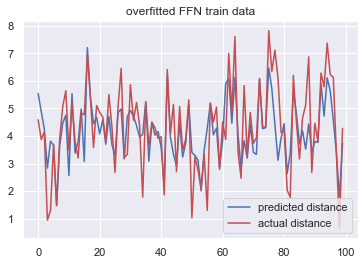

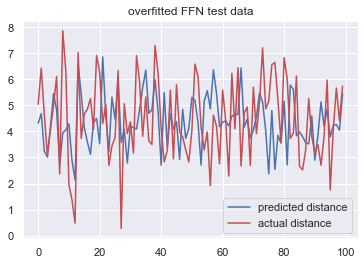

In [214]:
overfitted_data = model.predict(train_data_d[0])
overfitted_data = overfitted_data[:,0]

distance_prediction = model.predict(test_data_d[0])
distance_prediction = distance_prediction[:,0]

plt.plot(overfitted_data[0:100], color = 'b', label = "predicted distance")
plt.plot(train_data_d[1][0:100], color = 'r', label = 'actual distance')
plt.title("overfitted FFN train data")
plt.legend()
plt.show()

plt.plot(distance_prediction[0:100], color = 'b', label = "predicted distance")
plt.plot(test_data_d[1][0:100], color = 'r', label = 'actual distance')
plt.title("overfitted FFN test data")
plt.legend()
plt.show()

A feed forward network is possible to overtrain and match the data very well. This gives more credibility to the concept of a dynamic brain. The idea that nodes and layers are necessary in order to model kinematic data is true. However, when presented with new data, the same model is not a strong predictor of motion. This can be addressed by using a validation test set to see if the model is learning against this set as well. Once validation loss exceeds training loss, then the model will start to overfit. The next thing to look at, is even if training can be manually stopped earlier, how does PCA decomposition affect the results?

In [226]:
model_distance = constructFFN(1,129,'relu')
model_distance.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mean_absolute_error',metrics=['mean_squared_error'])
model_distance.fit(train_data_d[0],train_data_d[1], epochs = 3, verbose = 1, validation_split = 0.4)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
801/807 [============================>.] - ETA: 0s - loss: 2.1763 - mean_squared_error: 7.3507WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc2d3ea9b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

In [227]:
distance_prediction = model_distance.predict(test_data_d[0])
distance_prediction = distance_prediction[:,0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - 0s 914us/step


In [233]:
model_distance_pca = constructFFN(1,129,'relu')
model_distance_pca.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mean_absolute_error',metrics=['mean_squared_error'])
model_distance_pca.fit(train_data_pca_d[0],train_data_pca_d[1], epochs = 3, verbose = 1, validation_split = 0.4)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
802/807 [============================>.] - ETA: 0s - loss: 2.4598 - mean_squared_error: 8.9833WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc2d2ff37a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

In [234]:
distance_prediction_pca = model_distance_pca.predict(test_data_pca_d[0])
distance_prediction_pca = distance_prediction_pca[:,0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - 0s 1ms/step


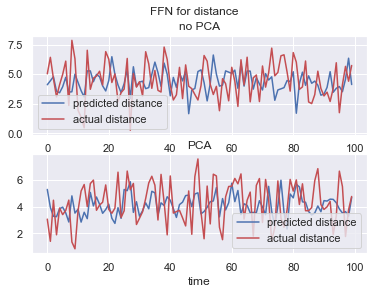

In [235]:
fig, axs = plt.subplots(2)
fig.suptitle('FFN for distance')
axs[0].plot(distance_prediction[0:100], color = 'b', label = "predicted distance")
axs[0].plot(test_data_d[1][0:100], color = 'r', label = 'actual distance')
axs[0].title.set_text("no PCA")
axs[1].plot(distance_prediction_pca[0:100], color = 'b', label = "predicted distance")
axs[1].plot(test_data_pca_d[1][0:100], color = 'r', label = 'actual distance')
axs[1].title.set_text("PCA")

for i,j in enumerate(axs):
    axs[i].legend()
plt.xlabel('time')
plt.show()

It is hard to say how PCA affects distance data. The same test will be ran against velocity data.

In [237]:
model_velocity_pca = constructFFN(1,129,'relu')
model_velocity_pca.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mean_absolute_error',metrics=['mean_squared_error'])
model_velocity_pca.fit(train_data_pca_v[0],train_data_pca_v[1], epochs = 2, verbose = 1, validation_split = 0.4)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
763/807 [===========================>..] - ETA: 0s - loss: 1.4566 - mean_squared_error: 5.8892WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc2c58af950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

In [240]:
velocity_prediction_pca = model_velocity_pca.predict(test_data_pca_v[0])
velocity_prediction_pca = velocity_prediction_pca[:,0]

150/150 [==============================] - 0s 952us/step


In [242]:
model_velocity = constructFFN(1,129,'relu')
model_velocity.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mean_absolute_error',metrics=['mean_squared_error'])
model_velocity.fit(train_data_v[0],train_data_v[1], epochs = 2, verbose = 1, validation_split = 0.4)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
770/807 [===========================>..] - ETA: 0s - loss: 1.4462 - mean_squared_error: 5.8031WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc2c54c77a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

In [244]:
velocity_prediction = model_velocity.predict(test_data_v[0])
velocity_prediction = velocity_prediction[:,0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - 0s 915us/step


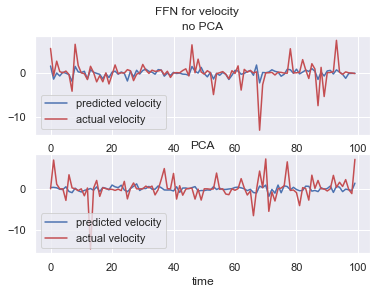

In [245]:
fig, axs = plt.subplots(2)
fig.suptitle('FFN for velocity')
axs[0].plot(velocity_prediction[0:100], color = 'b', label = "predicted velocity")
axs[0].plot(test_data_v[1][0:100], color = 'r', label = 'actual velocity')
axs[0].title.set_text("no PCA")
axs[1].plot(velocity_prediction_pca[0:100], color = 'b', label = "predicted velocity")
axs[1].plot(test_data_pca_v[1][0:100], color = 'r', label = 'actual velocity')
axs[1].title.set_text("PCA")

for i,j in enumerate(axs):
    axs[i].legend()
plt.xlabel('time')
plt.show()

It seems that some necessary data is lost through PCA for accurate predictions. 

## Constructing a Recurrent Neural Network

In [301]:
import numpy as np
from scipy.ndimage.interpolation import shift

In [276]:
data = unsorted_raster_pca_48ms[0]
print(data.shape)
distance_data = binned_unsorted_raster_48ms[1]
distance_data = np.abs(np.array(distance_data))
velocity_data = binned_unsorted_raster_48ms[2]
velocity_data = np.abs(np.array(velocity_data))
acceleration_data = binned_unsorted_raster_48ms[3]
acceleration_data = np.abs(np.array(acceleration_data))


print(velocity_data.shape)

(47805, 129)
(47805,)


In [277]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data = sc.fit_transform(data)

In [289]:
data.shape

(47805, 129)

In [326]:
test_shift = data[:,0]

In [327]:
for i in len()
shifted_data = shift(test_shift, 1, cval=np.NaN)

In [331]:
test_shift[0:100]

array([-0.62981548, -0.30400314,  1.55184308,  2.31803571,  3.01677391,
        1.66436598,  0.85843702,  1.38064551,  0.8495536 ,  1.20875128,
       -0.06260745, -0.08542419, -0.49720987, -0.47472932,  1.08456389,
       -0.01511928,  1.54166783,  1.07553618,  1.55461102,  0.38851037,
        0.94351622,  0.95046511,  0.23498262,  1.07780874,  1.07152558,
        1.83202631,  1.30406498,  0.86925874,  1.33084037,  0.64358711,
        0.59767465, -0.19513963,  0.49187673,  0.59809942,  1.06720688,
       -0.75049141, -0.95633138, -0.87477385, -0.94891766, -1.14375363,
       -0.49208245, -0.73062363,  0.4560476 ,  1.93368264,  2.21171753,
        0.83438956,  0.80200168,  1.29151966,  0.11925223, -0.38573184,
        0.46386957,  0.98573857,  1.91187651,  0.89793494,  0.95037864,
       -0.43165863, -0.7404993 , -0.72594577, -0.86717376, -0.04842591,
        0.83979457, -0.1193888 ,  1.21076945,  1.34466994,  0.74273504,
        1.80548689,  0.76511908,  1.28844112,  0.21516466,  0.37

In [332]:
shifted_data[0:100]

array([        nan, -0.62981548, -0.30400314,  1.55184308,  2.31803571,
        3.01677391,  1.66436598,  0.85843702,  1.38064551,  0.8495536 ,
        1.20875128, -0.06260745, -0.08542419, -0.49720987, -0.47472932,
        1.08456389, -0.01511928,  1.54166783,  1.07553618,  1.55461102,
        0.38851037,  0.94351622,  0.95046511,  0.23498262,  1.07780874,
        1.07152558,  1.83202631,  1.30406498,  0.86925874,  1.33084037,
        0.64358711,  0.59767465, -0.19513963,  0.49187673,  0.59809942,
        1.06720688, -0.75049141, -0.95633138, -0.87477385, -0.94891766,
       -1.14375363, -0.49208245, -0.73062363,  0.4560476 ,  1.93368264,
        2.21171753,  0.83438956,  0.80200168,  1.29151966,  0.11925223,
       -0.38573184,  0.46386957,  0.98573857,  1.91187651,  0.89793494,
        0.95037864, -0.43165863, -0.7404993 , -0.72594577, -0.86717376,
       -0.04842591,  0.83979457, -0.1193888 ,  1.21076945,  1.34466994,
        0.74273504,  1.80548689,  0.76511908,  1.28844112,  0.21

In [258]:
step = 1
data.shape[0]
data.shape[0]/1

data = np.reshape(data, (int(data.shape[0]/step),step,data.shape[1]))

In [275]:
data.shape

(47805, 1, 129)

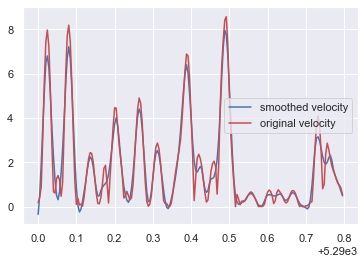

In [259]:
smoothed_velocity = savgol_filter(velocity_data, 11, 3)
plt.plot(time[0:200], smoothed_velocity[0:200], label = 'smoothed velocity')
plt.plot(time[0:200], velocity_data[0:200], color = 'r', label = 'original velocity')
plt.legend()
plt.show()

In [260]:
velocity_data = smoothed_velocity

In [261]:
data.shape

(47805, 1, 129)

In [262]:
# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(data,velocity_data, test_size = 0.2)
test_split = .8
cutoff = data.shape[0] * test_split
cutoff = int(cutoff)
x_train = data[:cutoff,:,:]
x_test  = data[cutoff:,:,:]
y_train = velocity_data[:cutoff]
y_test  = velocity_data[cutoff:]

In [263]:
step = 1
batch_size = 10

RNN = tf.keras.models.Sequential()
RNN.add(layers.LSTM(units = 129, input_shape = (step, 129),
                    activation = 'relu', return_sequences = True))
RNN.add(layers.Dropout(0.2))
RNN.add(layers.Dense(129,activation = 'relu'))
RNN.add(layers.LSTM(units = 129, input_shape = (step, 129),
                    activation = 'relu', return_sequences = False, return_state = False))
RNN.add(layers.Dropout(0.2))
RNN.add(layers.Dense(64, activation = 'relu'))
RNN.add(layers.Dense(32))
RNN.add(layers.Dense(1))

In [265]:
RNN.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mean_squared_error',metrics = ['mean_absolute_error']) 

In [266]:
RNN.fit(x_train, y_train,batch_size = 10, epochs=7, verbose=1, validation_split=0.2)

Epoch 1/7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3059/3060 [============================>.] - ETA: 0s - loss: 4.1426 - mean_absolute_error: 1.3266WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc2f1e994d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

In [153]:
RNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 129)            133644    
                                                                 
 dropout_2 (Dropout)         (None, 1, 129)            0         
                                                                 
 dense_41 (Dense)            (None, 1, 129)            16770     
                                                                 
 lstm_3 (LSTM)               (None, 129)               133644    
                                                                 
 dropout_3 (Dropout)         (None, 129)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                8320      
                                                                 
 dense_43 (Dense)            (None, 32)              

In [160]:
unsorted_raster_velocity_prediction = RNN.predict(x_train)

1196/1196 [==============================] - 2s 1ms/step


In [161]:
unsorted_raster_velocity_prediction = unsorted_raster_velocity_prediction[:,0]

In [162]:
y_train.size

38244

In [163]:
unsorted_raster_velocity_prediction.size

38244

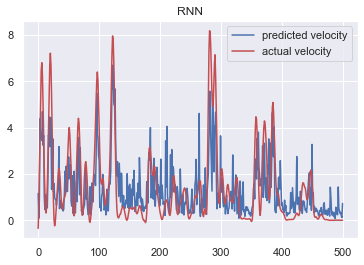

In [164]:
plt.plot(unsorted_raster_velocity_prediction[0:500], color = 'b', label = "predicted velocity")
plt.plot(y_train[0:500], color = 'r', label = 'actual velocity')
plt.title("RNN")
plt.legend()
plt.show()